# Lab 4: World Progress, Randomization

Welcome to lab 4!  

This lab brings together many of the topics so far, including data table manipulation, visualization, iteration and probability. The first few parts of the lab is based on a series of talks by Hans Rosling, a statistician who advised many world leaders about the changing state of the world's population. 

(Optional) For a video introduction to the topic of Global population change, you can watch Hans Rosling's video, [Don't Panic: The Facts About Population](https://www.gapminder.org/videos/dont-panic-the-facts-about-population/).

First, set up the imports by running the cell below.

In [105]:
# Run this cell to set up the notebook, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

The global population of humans reached 1 billion around 1800, 3 billion around 1960, and 7 billion around 2011. The potential impact of exponential population growth has concerned scientists, economists, and politicians alike.

The UN Population Division estimates that the world population will likely continue to grow throughout the 21st century, but at a slower rate, perhaps reaching 11 billion by 2100. However, the UN does not rule out scenarios of more extreme growth.

<a href="http://www.pewresearch.org/fact-tank/2015/06/08/scientists-more-worried-than-public-about-worlds-growing-population/ft_15-06-04_popcount/"> 
 <img src="pew_population_projection.png" alt="Estimated and project annual world population from 1950 to 2100.  Estimates in 1950 start at 2 billion and grow to 6 billion in 2000.  Projects say the population in 2100 will be 10.9 billion people."/>
</a>

In this section, we will examine some of the factors that influence population growth and how they are changing around the world.

The first table we will consider is the total population of each country over time. Run the cell below.

In [106]:
# The population.csv file can also be found online here:
# https://github.com/open-numbers/ddf--gapminder--systema_globalis/raw/master/ddf--datapoints--population_total--by--geo--time.csv
population = Table.read_table('population.csv')
population.show(3)

geo,time,population_total
abw,1800,19286
abw,1801,19286
abw,1802,19286


## 1. Bangladesh

In the `population` table, the `geo` column contains three-letter codes established by the [International Organization for Standardization](https://en.wikipedia.org/wiki/International_Organization_for_Standardization) (ISO) in the [Alpha-3](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3#Current_codes) standard. We will begin by taking a close look at Bangladesh. Inspect the standard to find the 3-letter code for Bangladesh.

**Question 1.1** <br/>Create a table called `b_pop` that has two columns labeled `time` and `population_total`. The first column should contain the years from 1970 through 2015 (including both 1970 and 2015) and the second should contain the population of Bangladesh in each of those years.

In [107]:
b_pop = population.where('geo', 'bgd').where('time', are.above_or_equal_to(1970)).where('time', are.below_or_equal_to(2015)).drop('geo')
b_pop

time,population_total
1970,65048701
1971,66417450
1972,67578486
1973,68658472
1974,69837960
1975,71247153
1976,72930206
1977,74848466
1978,76948378
1979,79141947


Run the following cell to create a table called `b_five` that has the population of Bangladesh every five years. At a glance, it appears that the population of Bangladesh has been growing quickly indeed!

In [108]:
b_pop.set_format('population_total', NumberFormatter)

fives = np.arange(1970, 2016, 5) # 1970, 1975, 1980, ...
b_five = b_pop.sort('time').where('time', are.contained_in(fives))
b_five

time,population_total
1970,"65,048,701"
1975,"71,247,153"
1980,"81,364,176"
1985,"93,015,182"
1990,"105,983,136"
1995,"118,427,768"
2000,"131,280,739"
2005,"142,929,979"
2010,"151,616,777"
2015,"160,995,642"


Run the next cell to create a table called `b_five_growth` which shows the growth rate for each five-year period from 1970 through 2010.

In [109]:
b_1970_through_2010 = b_five.where('time', are.below_or_equal_to(2010))
b_five_growth = b_1970_through_2010.with_column('annual_growth', (b_five.exclude(0).column(1)/b_1970_through_2010.column(1))**0.2-1)
b_five_growth.set_format('annual_growth', PercentFormatter)

time,population_total,annual_growth
1970,"65,048,701",1.84%
1975,"71,247,153",2.69%
1980,"81,364,176",2.71%
1985,"93,015,182",2.64%
1990,"105,983,136",2.25%
1995,"118,427,768",2.08%
2000,"131,280,739",1.71%
2005,"142,929,979",1.19%
2010,"151,616,777",1.21%


While the population has grown every five years since 1970, the annual growth rate decreased dramatically from 1985 to 2005. Let's look at some other information in order to develop a possible explanation. Run the next cell to load three additional tables of measurements about countries over time.

In [110]:
life_expectancy = Table.read_table('life_expectancy.csv')
child_mortality = Table.read_table('child_mortality.csv').relabeled(2, 'child_mortality_under_5_per_1000_born')
fertility = Table.read_table('fertility.csv')
life_expectancy.show(2)
child_mortality.show(2)
fertility.show(2)

geo,time,life_expectancy_years
afg,1800,28.21
afg,1801,28.2


geo,time,child_mortality_under_5_per_1000_born
afg,1800,468.6
afg,1801,468.6


geo,time,children_per_woman_total_fertility
afg,1800,7
afg,1801,7


The `life_expectancy` table contains a statistic that is often used to measure how long people live, called *life expectancy at birth*. This number, for a country in a given year, [does not measure how long babies born in that year are expected to live](http://blogs.worldbank.org/opendata/what-does-life-expectancy-birth-really-mean). Instead, it measures how long someone would live, on average, if the *mortality conditions* in that year persisted throughout their lifetime. These "mortality conditions" describe what fraction of people at each age survived the year. So, it is a way of measuring the proportion of people that are staying alive, aggregated over different age groups in the population.

The `fertility` table contains a statistic that is often used to measure how many babies are being born, the *total fertility rate*. This number describes the [number of children a woman would have in her lifetime](https://www.measureevaluation.org/prh/rh_indicators/specific/fertility/total-fertility-rate), on average, if the current rates of birth by age of the mother persisted throughout her child bearing years, assuming she survived through age 49. 

**Question 1.2.** <br/>Write a function `fertility_over_time` that takes the Alpha-3 code of a `country` and a `start` year. It returns a two-column table with labels "`Year`" and "`Children per woman`" (in that order) that can be used to generate a line chart of the country's fertility rate each year, starting at the `start` year. The plot should include the `start` year and all later years that appear in the `fertility` table. 

Then, in the next cell, call your `fertility_over_time` function on the Alpha-3 code for Bangladesh and the year 1970 in order to plot how Bangladesh's fertility rate has changed since 1970. Note that the function `fertility_over_time` should not return the plot itself **The expression that draws the line plot is provided for you; please don't change it.**

In [111]:
def fertility_over_time(country, start):
    """Create a two-column table that describes a country's total fertility rate each year."""
    country_fertility = fertility.where('geo', country).drop('geo')
    country_fertility_after_start = country_fertility.where('time', are.above_or_equal_to(start))
    return country_fertility_after_start

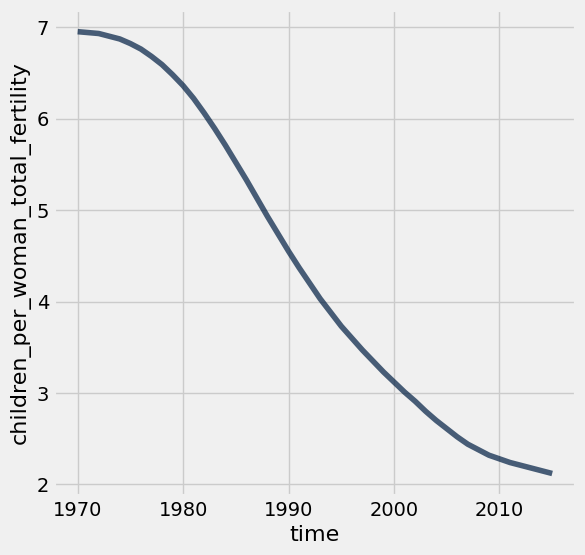

In [112]:
bangladesh_code = 'bgd'
fertility_over_time(bangladesh_code, 1970).plot(0, 1) # You should *not* change this line.

**Question 1.3.** <br/>Using both the `fertility` and `child_mortality` tables, draw a scatter diagram with one point for each year, starting with 1970, that has Bangladesh's total fertility on the horizontal axis and its child mortality on the vertical axis. 

**The expression that draws the scatter diagram is provided for you; please don't change it.** Instead, create a table called `post_1969_fertility_and_child_mortality` with the appropriate column labels and data in order to generate the chart correctly. Use the label "`Children per woman`" to describe total fertility and the label "`Child deaths per 1000 born`" to describe child mortality.

The lines `bgd_fertility`, `bgd_child_mortality`, and `fertility_and_child_mortality` are there to help you answer the question. You do not need to use them, but make sure you assign the correct table to `post_1969_fertility_and_child_mortality`.

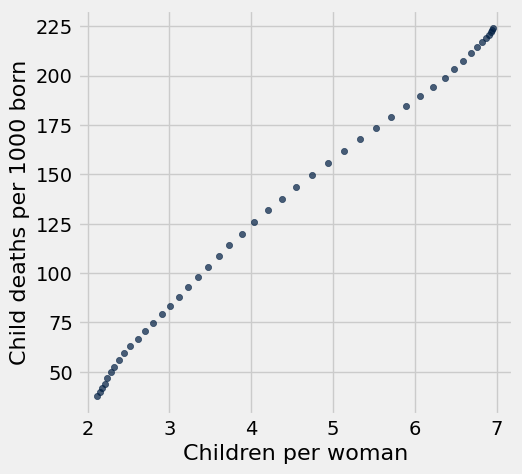

In [113]:
bgd_fertility = fertility.where('geo', bangladesh_code).drop('geo')
bgd_child_mortality = child_mortality.where('geo', bangladesh_code).drop('geo')
fertility_and_child_mortality = bgd_fertility.with_column('Child deaths per 1000 born', bgd_child_mortality.column(1)).relabel('children_per_woman_total_fertility', 'Children per woman')
post_1969_fertility_and_child_mortality = fertility_and_child_mortality.where('time', are.above_or_equal_to(1970))
post_1969_fertility_and_child_mortality.scatter('Children per woman', 'Child deaths per 1000 born') # You should *not* change this line.

## 2. The World

The change observed in Bangladesh since 1970 can also be observed in many other developing countries: health services improve, life expectancy increases, and child mortality decreases. At the same time, the fertility rate often plummets, and so the population growth rate decreases despite increasing longevity.

Run the next cell to see a line plot of the world population from 1800 through 2005.  You might recognize some of the code used!

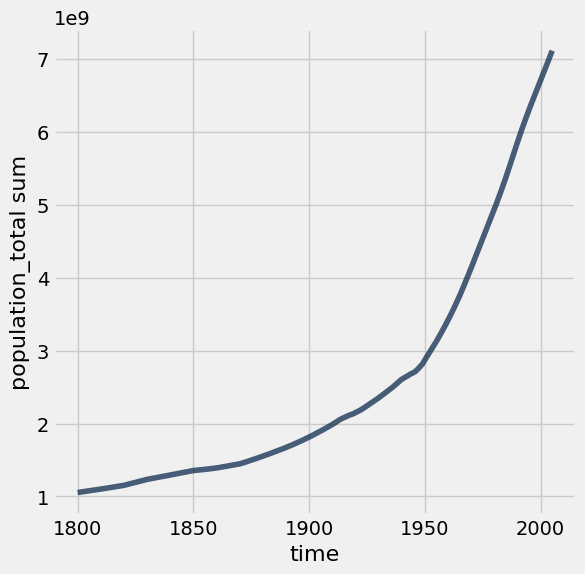

In [114]:
population.where('time', are.between(1800, 2006)).drop('geo').group('time', sum).plot(0)

**Question 2.1.** Create a function `stats_for_year` that takes a `year` and returns a table of statistics. The table it returns should have four columns: `geo`, `population_total`, `children_per_woman_total_fertility`, and `child_mortality_under_5_per_1000_born`. Each row should contain one Alpha-3 country code and three statistics: population, fertility rate, and child mortality for that `year` from the `population`, `fertility` and `child_mortality` tables. Only include rows for which all three statistics are available for the country and year.

In addition, restrict the result to country codes that appears in `big_50`, an array of the 50 most populous countries in 2010. This restriction will speed up computations later in the project.

*Hint*: What is the common column among all of the datasets? 

In [115]:
# We first create a population table that only includes the 
# 50 countries with the largest 2010 populations. We focus on 
# these 50 countries only so that plotting later will run faster.
big_50 = population.where('time', 2010).sort(2, descending=True).take(np.arange(50)).column('geo')
population_of_big_50 = population.where('time', are.above(1959)).where('geo', are.contained_in(big_50))

def stats_for_year(year):
    """Return a table of the stats for each country that year."""
    p = population_of_big_50.where('time', year).drop('time')
    f = fertility.where('time', year).drop('time')
    c = child_mortality.where('time', year).drop('time')
    return p.join('geo', f).join('geo', c)

Try calling your function `stats_for_year` on any year between 1960 and 2010 in the cell below.  Try to understand the output of `stats_for_year`.

In [116]:
stats_for_year(1970)

geo,population_total,children_per_woman_total_fertility,child_mortality_under_5_per_1000_born
afg,11121097,7.67,307.8
arg,23973062,3.07,72.4
bgd,65048701,6.95,224.1
bra,95982453,5.02,133.7
can,21439200,2.31,22
chn,808510713,5.75,113.3
cod,20009902,6.21,248.1
col,22061214,5.6,97.6
deu,78366605,2.04,25.7
dza,14550033,7.64,242.2


**Question 2.2.** <br/>Create a table called `pop_by_decade` with two columns called `decade` and `population`. It has a row for each `year` since 1960 that starts a decade. The `population` column contains the total population of all countries included in the result of `stats_for_year(year)` for the first `year` of the decade. For example, 1960 is the first year of the 1960's decade. You should see that these countries contain most of the world's population.

*Hint:* It may be helpful to use the provided `pop_for_year` that computes this total population, then `apply` it to the `decade` column.

In [117]:
def pop_for_year(year):
    return sum(stats_for_year(year).column('population_total'))
pop_for_year(1970)

3211487418

In [118]:
decades = Table().with_column('decade', np.arange(1960, 2011, 10))

pop_by_decade = decades.with_column('population', decades.apply(pop_for_year, 'decade'))
pop_by_decade.set_format(1, NumberFormatter)

decade,population
1960,"2,624,944,597"
1970,"3,211,487,418"
1980,"3,880,722,003"
1990,"4,648,434,558"
2000,"5,367,553,063"
2010,"6,040,810,517"


The `countries` table describes various characteristics of countries. The `country` column contains the same codes as the `geo` column in each of the other data tables (`population`, `fertility`, and `child_mortality`). The `world_6region` column classifies each country into a region of the world. Run the cell below to inspect the data.

In [119]:
countries = Table.read_table('countries.csv').where('country', are.contained_in(population.group('geo').column(0)))
countries.select('country', 'name', 'world_6region')

country,name,world_6region
afg,Afghanistan,south_asia
akr_a_dhe,Akrotiri and Dhekelia,europe_central_asia
alb,Albania,europe_central_asia
dza,Algeria,middle_east_north_africa
asm,American Samoa,east_asia_pacific
and,Andorra,europe_central_asia
ago,Angola,sub_saharan_africa
aia,Anguilla,america
atg,Antigua and Barbuda,america
arg,Argentina,america


**Question 2.3.** <br/>Create a table called `region_counts` that has two columns, `region` and `count`. It should describe the count of how many countries in each region appear in the result of `stats_for_year(1960)`. For example, one row would have `south_asia` as its `world_6region` value and an integer as its `count` value: the number of large South Asian countries for which we have population, fertility, and child mortality numbers from 1960.

*Hint:* What table method lets us find and count the number of unique values in a column? 

In [120]:
region_counts = countries.group('world_6region').sort('count', descending=True)
region_counts

world_6region,count
europe_central_asia,72
america,53
sub_saharan_africa,52
east_asia_pacific,46
middle_east_north_africa,23
south_asia,8
nan,1


The following scatter diagram compares total fertility rate and child mortality rate for each country in 1960. The area of each dot represents the population of the country. Run the cell. Do you think you can identify any of the dots?

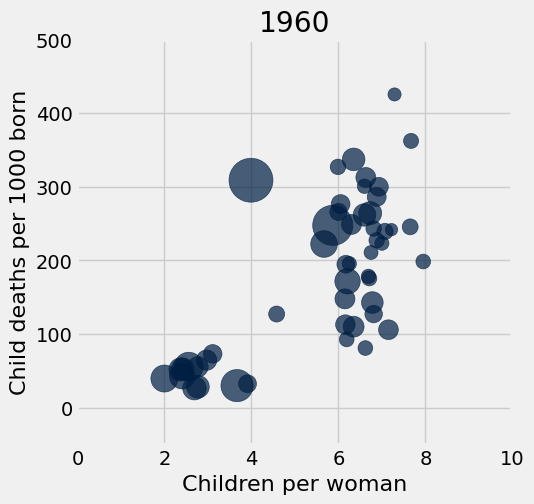

In [121]:
from functools import lru_cache as cache

# This cache annotation makes sure that if the same year
# is passed as an argument twice, the work of computing
# the result is only carried out once and then saved.
@cache(None)
def stats_relabeled(year):
    """Relabeled and cached version of stats_for_year."""
    return stats_for_year(year).relabeled(2, 'Children per woman').relabeled(3, 'Child deaths per 1000 born')

def fertility_vs_child_mortality(year):
    """Draw a scatter diagram comparing child mortality and fertility with the country's size"""
    with_region = stats_relabeled(year).join('geo', countries.select('country', 'world_6region'), 'country')
    with_region.scatter(2, 3, sizes=1, s=500)
    plots.xlim(0,10)
    plots.ylim(-50, 500)
    plots.title(year)

fertility_vs_child_mortality(1960)

The result of the cell below is interactive. It may take several minutes to run because it computers 55 tables (one for each year). When it's done, a scatter plot and a slider should appear.

Drag the slider to the right to see how countries have changed over time. You'll find that the great divide between so-called "Western" and "developing" countries that existed in the 1960's has nearly disappeared. This shift in fertility rates is the reason that the global population is expected to grow more slowly in the 21st century than it did in the 19th and 20th centuries.

In [122]:
import ipywidgets as widgets

# This part takes a few minutes to run because it 
# computes 55 tables in advance: one for each year.
for year in np.arange(1960, 2016):
    stats_relabeled(year)

_ = widgets.interact(fertility_vs_child_mortality, 
                     year=widgets.IntSlider(min=1960, max=2015, value=1960))

interactive(children=(IntSlider(value=1960, description='year', max=2015, min=1960), Output()), _dom_classes=(…

## 3. Nachos and Conditionals

In Python, Boolean values can either be `True` or `False`. We get Boolean values when using comparison operators such as `<` (less than), `>` (greater than), and `==` (equal to). A list of common comparison operators can be found below!

<img src="comparisons.png">

In [123]:
3 > 1 + 1

True

We can even assign the result of a comparison operation to a variable.

In [124]:
result = 10 / 2 == 5
result

True

Arrays are compatible with comparison operators. The output is an array of boolean values, where the comparison occurs *elementwise*.

In [125]:
make_array(1, 5, 7, 8, 3, -1) > 3

array([False,  True,  True,  True, False, False], dtype=bool)

Waiting on the dining table just for you is a hot bowl of nachos! Let's say that whenever you take a nacho, it will have cheese, salsa, both, or neither (just a plain tortilla chip). 

Using the function call `np.random.choice(array_name)`, let's simulate taking nachos from the bowl at random. Start by running the cell below several times, and observe how the results change.

If you don't understand how np.random.choice works, remember that you can check the documentation by typing `np.random.choice?`

In [126]:
nachos = make_array('cheese', 'salsa', 'both', 'neither')
np.random.choice(nachos)

'cheese'

**Question 3.1** <br/> Assume we took ten nachos at random, and stored the results in an array called `ten_nachos` as done below. Find the number of nachos with only cheese using code (do not hardcode the answer).  

*Hint:* Our solution involves a comparison operator and the `np.count_nonzero` method.

In [127]:
ten_nachos = make_array('neither', 'cheese', 'both', 'both', 'cheese', 'salsa', 'both', 'neither', 'cheese', 'both')
number_cheese = sum(ten_nachos == 'cheese')
number_cheese

3

**Conditional Statements**

A conditional statement is made up of many lines that allow Python to choose from different alternatives based on whether some condition is true.

Here is a basic example.

```
def sign(x):
    if x > 0:
        return 'Positive'
```

How the function works is if the input `x` is greater than `0`, we get the string `'Positive'` back.

If we want to test multiple conditions at once, we use the following general format.

```
if <if expression>:
    <if body>
elif <elif expression 0>:
    <elif body 0>
elif <elif expression 1>:
    <elif body 1>
...
else:
    <else body>
```

Only one of the bodies will ever be executed. Each `if` and `elif` expression is evaluated and considered in order, starting at the top. As soon as a true value is found, the corresponding body is executed, and the rest of the expression is skipped. If none of the `if` or `elif` expressions are true, then the `else body` is executed.

**Question 3.2** <br/>Complete the following conditional statement so that the string `'More please'` is assigned to `say_please` if the number of nachos with cheese in `ten_nachos` is less than `5`.

*Hint*: You should not have to reference the variable `ten_nachos`.

In [128]:
say_please = '?'

if number_cheese < 5:
    say_please = 'More please'
    
say_please

'More please'

**Question 3.3** <br/>Write a function called `nacho_reaction` that returns a string based on the type of nacho passed in as an argument. From top to bottom, the conditions should correspond to: `'cheese'`, `'salsa'`, `'both'`, `'neither'`.  

In [129]:
def nacho_reaction(nacho):
    if nacho == 'cheese':
        return 'Cheesy!'
    elif nacho == 'salsa':
        return 'Spicy!'
    elif nacho == 'both':
        return 'Wow!'
    else:
        return 'Meh.'

spicy_nacho = nacho_reaction('salsa')
spicy_nacho

'Spicy!'

**Question 3.4** <br/>Add a column `'Reactions'` to the table `ten_nachos_reactions` that consists of reactions for each of the nachos in `ten_nachos`. 

*Hint:* What table method should we use?

In [130]:
ten_nachos_reactions = Table().with_column('Nachos', ten_nachos)
ten_nachos_reactions = ten_nachos_reactions.with_column('Reactions', ten_nachos_reactions.apply(nacho_reaction, 'Nachos'))
ten_nachos_reactions

Nachos,Reactions
neither,Meh.
cheese,Cheesy!
both,Wow!
both,Wow!
cheese,Cheesy!
salsa,Spicy!
both,Wow!
neither,Meh.
cheese,Cheesy!
both,Wow!


**Question 3.5** <br/>Using code, find the number of `'Wow!'` reactions for the nachos in `ten_nachos_reactions`.

In [131]:
number_wow_reactions = np.count_nonzero(ten_nachos_reactions.column('Reactions') == 'Wow!')
number_wow_reactions

4

## 4. Simulations and For Loops
Using a `for` statement, we can perform a task multiple times. This is known as iteration. Here, we'll simulate drawing different suits from a deck of cards. 

In [132]:
suits = make_array("♤", "♡", "♢", "♧")

draws = make_array()

repetitions = 6

for i in np.arange(repetitions):
    draws = np.append(draws, np.random.choice(suits))

draws

array(['♢', '♡', '♧', '♧', '♡', '♡'],
      dtype='<U32')

The unrolled version of this `for` loop can be found below.

In [133]:
draws = make_array()

draws = np.append(draws, np.random.choice(suits))
draws = np.append(draws, np.random.choice(suits))
draws = np.append(draws, np.random.choice(suits))
draws = np.append(draws, np.random.choice(suits))
draws = np.append(draws, np.random.choice(suits))
draws = np.append(draws, np.random.choice(suits))

draws

array(['♡', '♧', '♡', '♤', '♧', '♢'],
      dtype='<U32')

In the example above, the `for` loop appends a random draw to the `draws` array for every number in `np.arange(repetitions)`. 

Here's a nice way to think of what we did above. We had a deck of 4 cards of different suits, we randomly drew one card, saw the suit, kept track of it in `draws`, and put the card back into the deck. We repeated this for a total of 6 times without having to repeat code, thanks to the `for` loop. We simulated this experiment using a `for` loop. 

Another use of iteration is to loop through a set of values. For instance, we can print out all of the colors of the rainbow.


In [134]:
rainbow = make_array("red", "orange", "yellow", "green", "blue", "indigo", "violet")

for color in rainbow:
    print(color)

red
orange
yellow
green
blue
indigo
violet


We can see that the indented part of the `for` loop, known as the body, is executed once for each item in `rainbow`. Note that the name `color` is arbitrary; we could easily have named it something else. The important thing is we stay consistent throughout the for loop. 

In [135]:
for another_name in rainbow:
    print(another_name)

red
orange
yellow
green
blue
indigo
violet


In general, however, we would like the variable name to be somewhat informative. 

**Question 4.1** <br/>Clay is playing darts. His dartboard contains ten equal-sized zones with point values from 1 to 10. Write code that simulates his total score after 1000 dart tosses. Make sure to use a `for` loop.

*Hint:* There are three steps to this problem (and most simulations): 
1. Deciding the possible values you can take in the experiment (point values in this case)
2. Running through the experiment a certain amount of times (running through 1000 dart tosses, and randomly getting a value per toss in this case)
3. Keeping track of the total information of each time you ran through the experiment (the total score in this case)
   
*Hint 2:* You can "update" a variable by setting it equal to itself because Python evaluates the right side first and then assigns it to the left name. For example:

`
x = 10 # Set the name x to the value 10
x = x + 5 # Take the current value of x, 10, and add it to 5. Then, reassign the name x to the calculated value, 15
`

In [136]:
possible_point_values = np.arange(1, 11)
tosses = 1000
total_score = 0

for _ in np.arange(tosses):
    total_score += np.random.choice(possible_point_values)

total_score

5375

**Question 4.2** <br/>In the following cell, we've loaded the text of _Pride and Prejudice_ by Jane Austen, split it into individual words, and stored these words in an array. Using a `for` loop, assign `longer_than_five` to the number of words in the novel that are more than 5 letters long.

*Hint*: You can find the number of letters in a word with the `len` function. Look at the `rainbow` example above for help.

In [137]:
austen_string = open('Austen_PrideAndPrejudice.txt', encoding='utf-8').read()
p_and_p_words = np.array(austen_string.split())

longer_than_five = 0

for word in p_and_p_words:
    if len(word) > 5:
        longer_than_five += 1

longer_than_five


35453

**Question 4.3** <br/>Using simulation with 10,000 trials, assign `chance_of_all_different` to an estimate of the chance that if you pick **three** words from Pride and Prejudice uniformly at random (with replacement), they all have **different lengths.**

*Hint*: Remember that `!=` only checks for non-equality between two items, not three. However, you can use `!=` more than once in the same line. 

For example, `2 != 3 != 4` first checks for non-equality between `2` and `3`, then `3` and `4`, but NOT `2` and `4`.

In [138]:
trials = 10000
different = 0

for _ in np.arange(trials):
    word1 = np.random.choice(p_and_p_words)
    word2 = np.random.choice(p_and_p_words)
    word3 = np.random.choice(p_and_p_words)
    
    if len(word1) != len(word2) and len(word2) != len(word3) and len(word1) != len(word3):
        different += 1

chance_of_all_different = different / trials
chance_of_all_different

0.6282

## 5. Finding Probabilities
After a long day of class, Clay decides to go to a food court for dinner. Today's menu has Clay's four favorite foods: enchiladas, hamburgers, pizza, and spaghetti. However, each dish has a 30% chance of running out before Clay can get to the food court.

**Question 5.1** <br/>What is the probability that Clay will be able to eat pizza at the food court?

In [139]:
pizza_prob = 0.7

**Question 5.2** <br/>What is the probability that Clay will be able to eat all four of these foods at the food court?

In [140]:
all_prob = 0.7 ** 4

**Question 5.3** <br/>What is the probability that the food court will have run out of at least 1 food before Clay can get there?

In [141]:
something_is_out = 1 - all_prob

To make up for their unpredictable food supply, the food court decides to hold a contest for some free food. There is a bag with two red marbles, two green marbles, and two blue marbles. Clay has to draw three marbles separately **without replacement**. In order to win, all three of these marbles must be of different colors.

**Question 5.4** <br/>What is the probability of Clay winning the contest?

*Hint:* For the first event, we can pick any marble -- what is that probability? Then, what's the probability of selecting a different marble? Finally, picking the color that hasn't been selected? 

In [142]:
winning_prob = (6 / 6) * (4 / 5) * (2 / 4)
winning_prob

0.4

## 6. Submission

To submit your assignment, please download your notebook as a .ipynb file and submit to Canvas. You can do so by navigating to the toolbar at the top of this page, clicking File > Download as... > Notebook (.ipynb) or HTML (.html). Then, upload your file under "Lab 4".
